# Importing libraries + loading Dataset

In [54]:
# === 1. Setup: Import Libraries and Initialize Environment ===

# Core utilities
import numpy as np
import pandas as pd
import re
from collections import Counter, defaultdict

# Dataset
from sklearn.datasets import fetch_20newsgroups

# Preprocessing: Stopwords, Tokenization, Stemming/Lemmatization
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Vectorization (BoW & TF-IDF)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Similarity measurement
from sklearn.metrics.pairwise import cosine_similarity

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Topic modeling (LDA)
from sklearn.decomposition import LatentDirichletAllocation

# Evaluation metrics
from sklearn.model_selection import train_test_split

# Ignore warnings for clarity
import warnings
warnings.filterwarnings("ignore")

print("Libraries imported successfully!")


Libraries imported successfully!


# **1. Data Collection — Imports & Dataset Loading**
This cell imports required libraries and loads the 20 Newsgroups dataset (5 selected categories). The dataset is loaded without headers/footers/quotes to focus on post content.


In [55]:
# === Imports, NLTK setup, and 20 Newsgroups loading ===

# Standard / utilities
from collections import Counter
import re
import numpy as np

# NLTK (for lemmatization/tokenization if needed)
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer

# scikit-learn (dataset + stopwords)
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Ensure small NLTK resources are available (safe to run even if already present)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Selected categories (5-topic subset for the project)
categories = [
    'comp.graphics',
    'sci.med',
    'rec.sport.baseball',
    'talk.politics.misc',
    'alt.atheism'
]

# Load dataset (remove headers/footers/quotes to focus on post body)
data = fetch_20newsgroups(
    subset='all',
    categories=categories,
    remove=('headers', 'footers', 'quotes')
)

documents = data.data
labels = data.target
label_names = data.target_names

# Quick check
print("Number of documents:", len(documents))
print("Categories:", label_names)
print("\nSample document:\n")
print(documents[0][:1000])  # first 1000 chars of the first document


Number of documents: 4531
Categories: ['alt.atheism', 'comp.graphics', 'rec.sport.baseball', 'sci.med', 'talk.politics.misc']

Sample document:

: >over where it places its temp files: it just places them in its
: >"current directory".

: I have to beg to differ on this point, as the batch file I use
: to launch cview cd's to the dir where cview resides and then
: invokes it.  every time I crash cview, the 0-byte temp file
: is found in the root dir of the drive cview is on.

I posted this as well before the cview "expert".  Apparently, he thought he
knew better.


## **2. Dataset Inspection**

In this step, we explore the dataset by checking:
- Number of documents per category  
- Basic statistics such as document length distribution  
- Short text samples from different classes  



In [56]:
from collections import Counter
import numpy as np
import nltk


docs = data.data
labels = data.target
label_names = data.target_names

# Counts per category
counts = Counter(labels)
for i,name in enumerate(label_names):
    print(f"{name:20s}: {counts[i]} documents")

# Document length stats (words)
lengths = [len(doc.split()) for doc in docs]
print("\nDocument length (words):")
print("  min:", min(lengths))
print("  max:", max(lengths))
print("  mean:", round(np.mean(lengths),1))
print("  median:", np.median(lengths))

# Show 3 short examples (first 200 chars)
print("\n--- Three short samples ---")
for i in [0, 50, 200]:
    print(f"\n[Sample doc index {i}, label={label_names[labels[i]]}]")
    print(docs[i][:200].replace('\n',' '))


alt.atheism         : 799 documents
comp.graphics       : 973 documents
rec.sport.baseball  : 994 documents
sci.med             : 990 documents
talk.politics.misc  : 775 documents

Document length (words):
  min: 0
  max: 9196
  mean: 196.5
  median: 82.0

--- Three short samples ---

[Sample doc index 0, label=comp.graphics]
: >over where it places its temp files: it just places them in its : >"current directory".  : I have to beg to differ on this point, as the batch file I use : to launch cview cd's to the dir where cvi

[Sample doc index 50, label=rec.sport.baseball]
 The New York talk shows are just awful in this regard.  People are constantly calling WFAN and WABC with (stuff like) "I was thinking, why don't the Yankees trade Kaminicki and Silvestri to Seattle f

[Sample doc index 200, label=talk.politics.misc]
  The above conveniently ignores the murder of four BATF agents by the Branch Davidians in an unprovoked ambush.  Any government that allows tinpot dictators to set up sho

## **3. Text Preprocessing Setup**

This cell defines the preprocessing pipeline, including:
- lowercasing,
- removing punctuation and URLs,
- tokenization,
- stopword removal,
- and lemmatization (or stemming).


In [57]:
import re
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

lemmatizer = WordNetLemmatizer()    # requires nltk wordnet
stemmer = PorterStemmer()
stop_words = set(ENGLISH_STOP_WORDS)  # scikit-learn stop words

def preprocess_text(text, do_lemmatize=True):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove URLs, emails and non-letter characters (keep spaces)
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    
    # 3. Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 4. Tokenize by whitespace and remove stopwords
    tokens = [t for t in text.split() if t not in stop_words and len(t) > 1]
    
    # 5. Lemmatize or stem
    if do_lemmatize:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    else:
        tokens = [stemmer.stem(t) for t in tokens]
    return ' '.join(tokens)


## 3.1 **Applying Preprocessing to the Corpus**

Here we apply the `preprocess_text()` function to all documents in the dataset.
This step cleans the text and prepares it for feature extraction (TF-IDF and Bag-of-Words).


In [58]:
# === Run preprocessing over all documents ===
import time
t0 = time.time()
docs_clean = [preprocess_text(d, do_lemmatize=True) for d in documents]  # set False to use stemmer if you didn't download wordnet
print("Preprocessing finished. Time: {:.1f}s".format(time.time()-t0))

# quick check
print("Sample cleaned doc:", docs_clean[0][:400], "...")


Preprocessing finished. Time: 2.3s
Sample cleaned doc: place temp file just place current directory beg differ point batch file use launch cview cd dir cview resides invokes time crash cview byte temp file root dir drive cview posted cview expert apparently thought knew better ...


# 3.2 **Vectorization – TF-IDF and Bag-of-Words**

We convert cleaned documents into numerical representations using:
- **TF-IDF**
- **Bag-of-Words (CountVectorizer)**

These vectorized forms will be used by the retrieval models.


In [59]:
from collections import defaultdict
import math

try:
    corpus = docs_clean  # preferred: preprocessed, cleaned texts
except NameError:
    try:
        corpus = documents  # fallback: raw loaded texts
    except NameError:
        corpus = None

if corpus is None:
    print("Warning: No corpus variable found (docs_clean or documents). Run preprocessing / data-loading cells first.")
else:
    # ensure all items are strings
    corpus = [str(d) for d in corpus]
    # tokenized: list of token lists (whitespace-split) for each document
    tokenized = [doc.split() for doc in corpus]

    # Build term frequency per doc and document frequencies
    term_freqs = []      # list of dicts: term -> freq for each doc
    doc_freq = defaultdict(int)  # term -> number of docs containing term
    for toks in tokenized:
        tf = defaultdict(int)
        seen = set()
        for t in toks:
            tf[t] += 1
            seen.add(t)
        term_freqs.append(tf)
        for t in seen:
            doc_freq[t] += 1

    N = len(tokenized)
    avgdl = float(sum(len(t) for t in tokenized)) / N if N > 0 else 0.0

    print(f"Prepared retrieval helpers: N={N}, avgdl={avgdl:.2f}, unique_terms={len(doc_freq)}")

Prepared retrieval helpers: N=4531, avgdl=92.47, unique_terms=30380


In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf = TfidfVectorizer(max_df=0.75, min_df=2, ngram_range=(1,1))
X_tfidf = tfidf.fit_transform(docs_clean)
print("TF-IDF matrix shape:", X_tfidf.shape)
print("Vocabulary size (TF-IDF):", len(tfidf.vocabulary_))

countvec = CountVectorizer(max_df=0.75, min_df=2, ngram_range=(1,1))
X_counts = countvec.fit_transform(docs_clean)
print("BoW matrix shape:", X_counts.shape)


TF-IDF matrix shape: (4531, 16573)
Vocabulary size (TF-IDF): 16573
BoW matrix shape: (4531, 16573)


# 3.3 **Exploratory Analysis – Top Terms per Category  (quick analytics)**

Using aggregated Bag-of-Words counts, we display the most frequent terms in each newsgroup category.  
This provides insight into distinguishing keywords for each topic.
 

In [61]:
# Compute top terms per category by aggregating TF or counts
import numpy as np
labels_arr = np.array(labels)
vocab = countvec.get_feature_names_out()

def top_terms_for_class(class_idx, topn=20):
    # sum counts for docs in this class
    idxs = np.where(labels_arr == class_idx)[0]
    sub = X_counts[idxs].sum(axis=0)  # 1 x V
    counts = np.asarray(sub).ravel()
    top_idx = counts.argsort()[::-1][:topn]
    return [(vocab[i], int(counts[i])) for i in top_idx]

for i, name in enumerate(label_names):
    print("\nTop terms for", name)
    print(top_terms_for_class(i, topn=15))



Top terms for alt.atheism
[('god', 702), ('people', 497), ('don', 436), ('say', 404), ('think', 374), ('atheist', 370), ('just', 351), ('doe', 343), ('religion', 324), ('belief', 306), ('know', 298), ('make', 293), ('atheism', 292), ('believe', 284), ('time', 276)]

Top terms for comp.graphics
[('image', 1680), ('file', 1062), ('graphic', 899), ('jpeg', 802), ('format', 653), ('program', 617), ('bit', 574), ('color', 516), ('data', 471), ('software', 457), ('available', 454), ('use', 443), ('ftp', 437), ('gif', 433), ('edu', 405)]

Top terms for rec.sport.baseball
[('game', 702), ('year', 639), ('team', 424), ('player', 377), ('don', 345), ('think', 338), ('run', 325), ('hit', 310), ('time', 309), ('good', 293), ('just', 270), ('baseball', 266), ('like', 265), ('pitcher', 226), ('know', 225)]

Top terms for sci.med
[('patient', 451), ('disease', 418), ('medical', 406), ('don', 364), ('health', 362), ('people', 360), ('know', 358), ('like', 357), ('time', 352), ('year', 349), ('use', 3

## **4. Retrieval Models**


# 4.1 **Vector Space Model (VSM) — Cosine Similarity Retrieval**

This section implements the Vector Space Model (VSM).  
- Documents and queries are represented as TF–IDF vectors.  
- Relevance is computed by **cosine similarity** between the query vector and each document vector.  
- We retrieve the top-k documents (highest cosine scores) and present a short snippet and label for each result.

Usage:
1. Provide a textual query (raw text).
2. The query is preprocessed the same way as the corpus (`preprocess_text`).
3. The preprocessed query is vectorized with the same `tfidf` vectorizer used for the corpus.
4. Cosine similarity scores are computed against `X_tfidf`.
5. Top-k documents are returned (index, score, label, snippet).


In [62]:
# === VSM Retrieval: cosine similarity ===
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def retrieve_vsm(raw_query, topk=10, show_snippet_chars=300):
    """
    Retrieve top-k documents using TF-IDF + cosine similarity.
    Assumes `preprocess_text`, `tfidf`, `X_tfidf`, `documents`, `labels`, `label_names` are in scope.
    Returns list of dicts with keys: idx, score, label_idx, label_name, snippet.
    """
    # 1. Preprocess query the same way as corpus
    q_proc = preprocess_text(raw_query, do_lemmatize=True)
    if not q_proc.strip():
        return []
    # 2. Vectorize using existing TF-IDF vectorizer
    q_vec = tfidf.transform([q_proc])
    # 3. Compute cosine similarity against corpus TF-IDF matrix
    sims = cosine_similarity(q_vec, X_tfidf).flatten()
    # 4. Rank documents by descending similarity
    top_idx = np.argsort(-sims)[:topk]
    results = []
    for i in top_idx:
        results.append({
            'idx': int(i),
            'score': float(sims[i]),
            'label_idx': int(labels[i]),
            'label_name': label_names[labels[i]],
            'snippet': documents[i][:show_snippet_chars].replace('\n', ' ')
        })
    return results

# --- Helper to pretty-print results ---
def print_vsm_results(results):
    if not results:
        print("No results (empty or very short query after preprocessing).")
        return
    for rank, r in enumerate(results, start=1):
        print(f"{rank:2d}. [Doc {r['idx']}] (score={r['score']:.4f}) - {r['label_name']}")
        print("    Snippet:", r['snippet'])
        print("")

# === Example usage ===
example_query = "tf idf and bm25 ranking"
print("Raw query:", example_query)
results = retrieve_vsm(example_query, topk=10)
print_vsm_results(results)


Raw query: tf idf and bm25 ranking
 1. [Doc 2996] (score=0.1488) - rec.sport.baseball
    Snippet:    Well then given your definition of "best" is it not conceivable that Alfredo Griffin could bring something to a team that that team needs to win while Larkin might not have that something the team needs? Would Griffin then be better than Larkin?     No, I am not trying to define the quality of an

 2. [Doc 2760] (score=0.0820) - rec.sport.baseball
    Snippet:    Unfortunately, you seem to lack the ability to rate players.  Dave Winfield has had a better career than half the people in the Hall of Fame.  Eddie Murray and Darrel Evans are both one of the top 100 players of all time.  Lee Smith has had probably the greatest long career of any relief pitcher 

 3. [Doc 3433] (score=0.0777) - talk.politics.misc
    Snippet:   In order of your questions, I oppose it, I oppose it, I oppose it and (Huh?  Wha?  Where did _that_ topic come from and what's it got to do with the discussion at hand

## **4.2 Boolean Retrieval Model**

**Goal:** implement a simple Boolean retrieval model that supports `AND`, `OR`, and `NOT` (and implicit AND when terms are space-separated).  
We build a fast inverted index (term → set of document indices), a query parser, and a retrieval function that returns matching documents and a simple relevance score (number of matched terms).


In [63]:
from collections import defaultdict

inverted_index = defaultdict(set)
for doc_id, text in enumerate(docs_clean):
    for term in set(text.split()):   # using unique terms per doc
        inverted_index[term].add(doc_id)

# Quick check
n_terms = len(inverted_index)
print(f"Inverted index built with {n_terms} terms.")
sample_terms = list(inverted_index.keys())[:12]
print("Sample terms:", sample_terms)


Inverted index built with 30380 terms.
Sample terms: ['knew', 'current', 'differ', 'root', 'file', 'time', 'posted', 'directory', 'thought', 'cview', 'place', 'launch']


In [64]:
# === Boolean query parser + evaluator ===
import re

def parse_boolean_query(q):
    """
    Normalize query:
    - supports ' OR ', ' NOT ' (case-insensitive)
    - default splitting uses spaces treated as AND
    Returns a dict representing the query type and terms.
    We'll support three simple forms:
      1) OR: 'a OR b OR c'  -> {'op':'OR', 'terms':[...]}
      2) NOT: 'a NOT b'      -> {'op':'NOT', 'include':[...], 'exclude':[...]}
      3) AND (default)       -> {'op':'AND', 'terms':[...]}
    """
    q = q.strip()
    # handle explicit OR
    if re.search(r'\s+or\s+', q, flags=re.I):
        parts = re.split(r'\s+or\s+', q, flags=re.I)
        terms = [t for t in [re.sub(r'[^a-z\s]',' ',p.lower()).strip() for p in parts] if t]
        # flatten multi-word parts into tokens (treat each token individually)
        flat = []
        for p in terms:
            flat.extend([tok for tok in p.split() if tok])
        return {'op':'OR', 'terms': flat}
    # handle NOT
    if re.search(r'\s+not\s+', q, flags=re.I):
        parts = re.split(r'\s+not\s+', q, flags=re.I)
        include = [tok for tok in re.sub(r'[^a-z\s]',' ',parts[0].lower()).split() if tok]
        exclude = [tok for tok in re.sub(r'[^a-z\s]',' ',parts[1].lower()).split() if tok] if len(parts)>1 else []
        return {'op':'NOT', 'include': include, 'exclude': exclude}
    # default AND (space separated)
    terms = [tok for tok in re.sub(r'[^a-z\s]',' ', q.lower()).split() if tok]
    return {'op':'AND', 'terms': terms}

def boolean_retrieve(query, topk=10):
    """
    Evaluate parsed query against inverted_index.
    Returns up to topk doc ids and a simple score (number of matched terms).
    - AND: intersection of postings for all terms.
    - OR: union of postings for any term (score = matched term count).
    - NOT: include docs containing all 'include' terms and NOT containing any 'exclude' terms.
    """
    parsed = parse_boolean_query(query)
    op = parsed['op']
    if op == 'AND':
        terms = parsed['terms']
        if not terms:
            return [], []
        # start with postings of first term
        res = inverted_index.get(terms[0], set()).copy()
        for t in terms[1:]:
            res &= inverted_index.get(t, set())
        # simple score: sum of term frequencies in those docs
        scores = []
        for d in res:
            s = sum(docs_clean[d].split().count(t) for t in terms)
            scores.append((d, s))
        scores_sorted = sorted(scores, key=lambda x: (-x[1], x[0]))[:topk]
        return [d for d,_ in scores_sorted], [sc for _,sc in scores_sorted]

    if op == 'OR':
        terms = parsed['terms']
        res_set = set()
        for t in terms:
            res_set |= inverted_index.get(t, set())
        scores = []
        for d in res_set:
            s = sum(1 for t in terms if t in docs_clean[d].split())
            scores.append((d, s))
        scores_sorted = sorted(scores, key=lambda x: (-x[1], x[0]))[:topk]
        return [d for d,_ in scores_sorted], [sc for _,sc in scores_sorted]

    if op == 'NOT':
        include = parsed.get('include', [])
        exclude = parsed.get('exclude', [])
        if not include:
            # If no include terms, treat as all docs excluding exclude terms
            res_set = set(range(len(docs_clean)))
        else:
            res_set = inverted_index.get(include[0], set()).copy()
            for t in include[1:]:
                res_set &= inverted_index.get(t, set())
        # remove excluded docs
        for e in exclude:
            res_set -= inverted_index.get(e, set())
        scores = []
        for d in res_set:
            s = sum(docs_clean[d].split().count(t) for t in include)
            scores.append((d, s))
        scores_sorted = sorted(scores, key=lambda x: (-x[1], x[0]))[:topk]
        return [d for d,_ in scores_sorted], [sc for _,sc in scores_sorted]

    return [], []


In [65]:
# === Helpers: snippet extractor and demo runs ===
def snippet_for_doc(doc_id, query_terms, window=30):
    # Show short snippet around the first occurrence of any query term
    text = documents[doc_id]
    lower = text.lower()
    for t in query_terms:
        pos = lower.find(t.lower())
        if pos!=-1:
            start = max(0, pos-window)
            end = min(len(text), pos+window)
            return '...'+text[start:end].replace('\n',' ') + '...'
    # fallback: return first 200 chars
    return text[:200].replace('\n',' ') + '...'

# Demo queries to try
demo_queries = [
    "tf idf bm25",        # space -> treated as AND (tf AND idf AND bm25)
    "tokenization OR stemming",
    "cancer NOT treatment"
]

for q in demo_queries:
    docs_ids, scores = boolean_retrieve(q, topk=8)
    print("\nQuery:", q)
    if not docs_ids:
        print("  No matching documents.")
        continue
    for rank, (d, s) in enumerate(zip(docs_ids, scores), start=1):
        print(f"  {rank}. [Doc {d}] (score={s}) - {label_names[labels[d]]}")
        print("     Snippet:", snippet_for_doc(d, q.split()))



Query: tf idf bm25
  No matching documents.

Query: tokenization OR stemming
  1. [Doc 3776] (score=1) - talk.politics.misc
     Snippet: ...his doctrine can be found in tort, bankruptcy or contract ca...

Query: cancer NOT treatment
  1. [Doc 2482] (score=7) - sci.med
     Snippet: ...Burzynski's method is in *The Cancer Industry* by pulitzer-p...
  2. [Doc 729] (score=6) - sci.med
     Snippet: ... effects against experimental cancer. The NCI conducted test...
  3. [Doc 516] (score=5) - sci.med
     Snippet: ............... 31      National Cancer Insitute Designated Can...
  4. [Doc 2668] (score=5) - sci.med
     Snippet: ...ell! :-) is to either destroy cancer cells or to keep them f...
  5. [Doc 1021] (score=4) - sci.med
     Snippet: ...your mother has a historyy of cancer?  I was just wondeing, ...
  6. [Doc 526] (score=3) - sci.med
     Snippet: ...wingly  introducing another.  Cancer mestastizes.  My imperf...
  7. [Doc 2160] (score=2) - sci.med
     Snippet: ...on's risk for

#### Boolean Retrieval Implementation
We constructed an **inverted index** mapping each preprocessed term to the set of documents that contain it. The Boolean query parser supports `AND`, `OR`, and `NOT`.  
- **AND** computes the intersection of postings lists (documents containing all terms).  
- **OR** computes the union of postings lists (documents containing any term).  
- **NOT** excludes documents that contain the negated term(s).  

A simple scoring heuristic (term-count in matched document) is used to order results for `OR` and `NOT` queries. Phrase queries and parentheses are not implemented in this basic version, but the index and parser can be extended to support them.


# **5. Model Implementation**

This section implements the query-processing pipeline and two retrieval methods:
- Vector Space Model (VSM) using TF–IDF and cosine similarity
- Boolean Retrieval (AND / OR / NOT over tokens)


Each retrieval function:
1. converts the raw query into the same preprocessed/tokenized form as documents,
2. computes scores,
3. returns top-k document indices and scores.


## ***Query preprocessing wrapper & snippet helper***

In [66]:
def preprocess_query(raw_query, do_lemmatize=True):
    """
    Preprocess a raw query string using the same pipeline as documents.
    Returns:
        query_text (str): the cleaned query string (space-separated tokens)
        tokens (list): token list
    """
    q_clean = preprocess_text(raw_query, do_lemmatize=do_lemmatize)
    tokens = q_clean.split()
    return q_clean, tokens

def get_snippet(doc_text, query_tokens, char_window=200):
    """
    Return a short snippet highlighting the first occurrence of any query token.
    If none found, return start of document.
    """
    if not doc_text:
        return ""
    lower = doc_text.lower()
    for tok in query_tokens:
        pos = lower.find(tok)
        if pos != -1:
            start = max(0, pos - char_window//4)
            end = min(len(doc_text), pos + char_window//2)
            snippet = doc_text[start:end].replace('\n',' ')
            return snippet[:char_window] + "..."
    # fallback: return the beginning
    return doc_text[:char_window].replace('\n',' ') + "..."


## 5.1 **Vector Space Model (VSM) — TF–IDF + Cosine Similarity**
- Converts the query to TF–IDF (using the fitted `tfidf` vectorizer)
- computes cosine similarity vs `X_tfidf`, and returns top-k ranked documents.


In [67]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def retrieve_vsm(raw_query, topk=10, do_lemmatize=True):
    q_clean, q_tokens = preprocess_query(raw_query, do_lemmatize=do_lemmatize)
    if q_clean.strip() == "":
        return np.array([]), np.array([])
    q_vec = tfidf.transform([q_clean])           # use fitted tfidf vectorizer
    sims = cosine_similarity(q_vec, X_tfidf).flatten()
    ranks = np.argsort(-sims)[:topk]
    return ranks, sims[ranks]

# Example usage:
# ranks, scores = retrieve_vsm("tf idf and bm25 ranking", topk=5)


## 5.2 **Boolean Retrieval Model**
Simple boolean retrieval supporting:
- AND (default when multiple tokens given)
- OR (use ' OR ' in query)
- NOT (use ' NOT ' to exclude tokens)

This operates on token sets created from `docs_clean` (variable `tokenized`).
It returns exact matches ordered by simple term-frequency score among matched terms.


# *Building the Inverted Index*

In [68]:
# Tokenize all cleaned documents
tokenized = [doc.split() for doc in docs_clean]

# Build term frequencies and inverted index
from collections import defaultdict

inverted_index = defaultdict(set)
term_freqs = []  # list of dicts -> term frequencies per document

for doc_id, tokens in enumerate(tokenized):
    tf = defaultdict(int)
    for token in tokens:
        tf[token] += 1
        inverted_index[token].add(doc_id)
    term_freqs.append(tf)

print("Inverted index built with", len(inverted_index), "terms.")

# show a few terms
print("Sample terms:", list(inverted_index.keys())[:12])


Inverted index built with 30380 terms.
Sample terms: ['place', 'temp', 'file', 'just', 'current', 'directory', 'beg', 'differ', 'point', 'batch', 'use', 'launch']


# *Boolean Query Processor*

In [69]:
# === Boolean Retrieval Model (AND, OR, NOT) ===

def boolean_retrieval(query):
    q = query.lower()

    # Tokenize query terms using same preprocessing
    def clean_query(text):
        return preprocess_text(text, do_lemmatize=True).split()

    if ' or ' in q:
        parts = [clean_query(p) for p in q.split(' or ')]
        result = set()
        for group in parts:
            for term in group:
                result |= inverted_index.get(term, set())
        return list(result)

    elif ' not ' in q:
        parts = q.split(' not ')
        include = clean_query(parts[0])
        exclude = clean_query(parts[1]) if len(parts) > 1 else []

        # start with AND for include
        result = None
        for term in include:
            docs = inverted_index.get(term, set())
            result = docs if result is None else result & docs

        # remove exclude terms
        for term in exclude:
            result -= inverted_index.get(term, set())

        return list(result)

    else:
        # AND query
        terms = clean_query(q)
        result = None
        for term in terms:
            docs = inverted_index.get(term, set())
            result = docs if result is None else result & docs
        return list(result) if result else []


# *Display Retrieved Documents (Boolean)*

In [70]:
# === Test Boolean Retrieval ===

def show_boolean_results(query, topn=10):
    matches = boolean_retrieval(query)
    if not matches:
        print("\nQuery:", query, "\n  No matching documents.")
        return
    
    print("\nQuery:", query)
    for i, doc_id in enumerate(matches[:topn]):
        print(f"  {i+1}. [Doc {doc_id}] - {label_names[labels[doc_id]]}")
        snippet = docs[doc_id][:200].replace('\n',' ')
        print("     Snippet:", snippet[:150], "...\n")


# Try some queries:
show_boolean_results("tokenization OR stemming")
show_boolean_results("cancer NOT treatment")
show_boolean_results("god AND religion")



Query: tokenization OR stemming
  1. [Doc 3776] - talk.politics.misc
     Snippet: I'm going to be mixing together here stuff from two of Ted Frank's articles, <1993Apr15.143623.25813@midway.uchicago.edu> (which was a response to me) ...


Query: cancer NOT treatment
  1. [Doc 516] - sci.med
     Snippet: ------------- cut here ----------------- Volume  6, Number 10                                           April 20, 1993                +--------------- ...

  2. [Doc 3974] - sci.med
     Snippet: Unfortonately, that truly is about the best summation of the research that there is.  Advantages stated of circumcison included probably prevention of ...

  3. [Doc 4106] - sci.med
     Snippet: My mom has just been diagnosed with cystic breast disease -- a big relief, as it was a lump that could have been cancer.  Her doctor says she should g ...

  4. [Doc 1549] - sci.med
     Snippet: I need information on the medical (including emotional :-) pros and cons of circumcision (at birth).  I 

# **6. Evaluation**

In this section we measure retrieval effectiveness using standard IR metrics:

- **Precision** — fraction of retrieved documents in top-k that are relevant.  
- **Recall** — fraction of all relevant documents that appear in the top-k results.  
- **Average Precision (AP)** for a single query — the average of precision values computed at ranks where relevant documents appear.  
- **Mean Average Precision (MAP)** — mean of AP over a set of queries.

**Relevance definition:** for evaluation we treat a document as relevant to a query if it belongs to the same category (label) as the query document. This is a common practical heuristic when gold relevance judgments are unavailable.


## ***Evaluation Metrics***
Evaluate Vector Space Model (VSM) and Boolean retrieval using:
- Precision
- Recall
- Mean Average Precision (MAP)

In [71]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import re
from collections import defaultdict

# VSM retrieval - TF-IDF + cosine
def retrieve_vsm(query, topk=10, vectorizer_name='tfidf', X_name='X_tfidf'):
    """
    query: raw string (will be preprocessed similarly to docs_clean if available)
    returns: (indices_array, scores_array)
    """
    # prefer docs_clean preprocessing if present: assume user preprocessed queries similarly
    try:
        processed_query = preprocess_text(query, do_lemmatize=True)
    except NameError:
        # fallback: lowercase + simple cleaning
        processed_query = re.sub(r'[^a-z\s]', ' ', query.lower())
    # use tfidf vectorizer variable name `tfidf` and matrix `X_tfidf` assumed present
    qvec = tfidf.transform([processed_query])
    sims = cosine_similarity(qvec, X_tfidf).flatten()
    ranks = np.argsort(-sims)[:topk]
    return ranks, sims[ranks]

# Boolean retrieval - simple AND semantics (all tokens must be in doc)
# Uses docs_clean if available (preprocessed), otherwise falls back to raw documents (lowercased, non-alpha removed)
def retrieve_boolean(query, topk=10):
    try:
        corpus_tokens = [set(d.split()) for d in docs_clean]  # preprocessed token sets
    except NameError:
        # basic fallback preprocessing
        corpus_tokens = [set(re.sub(r'[^a-z\s]', ' ', d.lower()).split()) for d in documents]

    # preprocess query similarly
    try:
        q_processed = preprocess_text(query, do_lemmatize=True)
    except NameError:
        q_processed = re.sub(r'[^a-z\s]', ' ', query.lower())

    q_terms = [t for t in q_processed.split() if t not in stop_words] if 'stop_words' in globals() else q_processed.split()
    if len(q_terms) == 0:
        return np.array([], dtype=int), np.array([])

    mask = []
    for toks in corpus_tokens:
        if all(term in toks for term in q_terms):
            mask.append(1)
        else:
            mask.append(0)
    mask = np.array(mask, dtype=bool)
    idxs = np.where(mask)[0][:topk]
    # compute a simple score (number of matched terms) to break ties
    scores = np.array([sum(1 for t in q_terms if t in (docs_clean[i].split() if 'docs_clean' in globals() else re.sub(r'[^a-z\s]', ' ', documents[i].lower()).split())) for i in idxs], dtype=float)
    return idxs, scores


## 6.1 **metric functions (Precision, Recall, AP, MAP)**

In [72]:
# === Evaluation metrics: precision@k, recall@k, AP, MAP ===
import numpy as np

def precision_at_k(retrieved, relevant_set, k=10):
    """
    retrieved: 1D iterable of doc indices (ints)
    relevant_set: set of relevant indices
    """
    if len(retrieved) == 0:
        return 0.0
    retrieved_k = list(retrieved)[:k]
    hits = sum(1 for d in retrieved_k if int(d) in relevant_set)
    return hits / k

def recall_at_k(retrieved, relevant_set, k=10):
    if len(relevant_set) == 0:
        return 0.0
    retrieved_k = list(retrieved)[:k]
    hits = sum(1 for d in retrieved_k if int(d) in relevant_set)
    return hits / len(relevant_set)

def average_precision(retrieved, relevant_set):
    """
    AP: average precision over ranks where relevant docs appear.
    retrieved: iterable of doc indices
    relevant_set: set of relevant doc indices
    """
    retrieved = list(retrieved)
    hits = 0
    score = 0.0
    for i, doc in enumerate(retrieved, start=1):
        if int(doc) in relevant_set:
            hits += 1
            score += hits / i
    if len(relevant_set) == 0:
        return 0.0
    return score / len(relevant_set)

def mean_average_precision(list_of_retrieved_lists, list_of_relevant_sets):
    aps = []
    for retrieved, relevant in zip(list_of_retrieved_lists, list_of_relevant_sets):
        aps.append(average_precision(retrieved, relevant))
    return float(np.mean(aps)) if aps else 0.0


## 6.2 **prepare evaluation queries & relevance sets**

(We generate queries from documents by extracting top terms of a document; relevance = same-category documents.)

In [73]:
# === Prepare evaluation queries and relevance sets ===
import numpy as np
from collections import Counter, defaultdict

# Choose a sample of document indices as queries.
# Option: pick random sample or specific indices. Here we pick 50 random documents stratified by label:
rng = np.random.RandomState(42)
num_queries = 50
all_indices = np.arange(len(documents))
if num_queries <= len(all_indices):
    sample_query_idxs = rng.choice(all_indices, size=num_queries, replace=False)
else:
    sample_query_idxs = all_indices

# Build a short query string for each sampled doc using its top 5 terms (from preprocessed doc)
def top_terms_from_doc(doc_text, topn=5):
    # assume docs_clean exists
    try:
        toks = docs_clean[doc_text].split()
    except Exception:
        toks = documents[doc_text].lower().split()
    top = [w for w, _ in Counter(toks).most_common(topn)]
    return ' '.join(top)

evaluation_queries = []
for qi in sample_query_idxs:
    qtext = top_terms_from_doc(qi, topn=5)
    evaluation_queries.append((int(qi), qtext))

# Build relevance sets: documents that share same label as the query-doc (excluding the query doc itself)
label_to_indices = defaultdict(list)
for idx, lbl in enumerate(labels):
    label_to_indices[int(lbl)].append(int(idx))

relevant_docs = {}
for qi, qtext in evaluation_queries:
    lbl = int(labels[qi])
    relevant_set = set(label_to_indices[lbl]) - {qi}
    relevant_docs[qtext] = relevant_set

print(f"Prepared {len(evaluation_queries)} evaluation queries.")


Prepared 50 evaluation queries.


## 6.3 **Evaluation Results: VSM vs Boolean Retrieval** 

In [74]:
# === Run retrieval for each evaluation query, compute metrics ===
results = []  # store per-query metrics

results_vsm = {}
results_bool = {}

for qi, qtext in evaluation_queries:
    # Run VSM
    v_idx, v_scores = retrieve_vsm(qtext, topk=len(documents))
    # Run Boolean
    b_idx, b_scores = retrieve_boolean(qtext, topk=len(documents))
    # Ensure we have plain 1D lists / arrays of ints
    v_idx = np.array(v_idx, dtype=int).flatten()
    b_idx = np.array(b_idx, dtype=int).flatten()

    rel_set = relevant_docs[qtext]

    # Metrics at k = 5, 10, 20
    for k in (5, 10, 20):
        p_v = precision_at_k(v_idx, rel_set, k=k)
        r_v = recall_at_k(v_idx, rel_set, k=k)
        p_b = precision_at_k(b_idx, rel_set, k=k)
        r_b = recall_at_k(b_idx, rel_set, k=k)

        # AP (full ranking)
        ap_v = average_precision(v_idx, rel_set)
        ap_b = average_precision(b_idx, rel_set)

        results.append({
            'query_idx': qi,
            'query_text': qtext,
            'k': k,
            'vsm_prec': p_v,
            'vsm_rec': r_v,
            'vsm_ap': ap_v,
            'bool_prec': p_b,
            'bool_rec': r_b,
            'bool_ap': ap_b,
            'relevant_count': len(rel_set)
        })

# Convert to DataFrame and show aggregated results
import pandas as pd
df_eval = pd.DataFrame(results)
agg = df_eval.groupby('k')[['vsm_prec','vsm_rec','vsm_ap','bool_prec','bool_rec','bool_ap']].mean().reset_index()
print("Aggregated evaluation (averaged over queries):")
display(agg)

# Save evaluation results
out_dir = "ir_outputs"
import os
os.makedirs(out_dir, exist_ok=True)
df_eval.to_csv(os.path.join(out_dir, "evaluation_vsm_boolean.csv"), index=False)
agg.to_csv(os.path.join(out_dir, "evaluation_summary_by_k.csv"), index=False)
print(f"Saved evaluation CSVs to {os.path.abspath(out_dir)}")


Aggregated evaluation (averaged over queries):


,k,vsm_prec,vsm_rec,vsm_ap,bool_prec,bool_rec,bool_ap
0,5,0.620,0.003359,0.289737,0.124,0.000651,0.000666
1,10,0.638,0.006865,0.289737,0.074,0.000773,0.000666
2,20,0.639,0.013798,0.289737,0.037,0.000773,0.000666


Saved evaluation CSVs to e:\OMAR IBRAHIM\SEMESTER 7\INFORMATION RETREIVAL\SECTIONS\FINAL PROJECT\ir_outputs


# **Enhanced Retrieval System with BM25**

This section adds:
1. **BM25 Retrieval** - Probabilistic ranking function
2. **Enhanced Boolean Retrieval** - With soft matching fallback
3. **Comprehensive Evaluation** - Compare all three models
4. **Visualizations** - Performance comparison plots
5. **Analysis** - Per-category, failure, and query length analysis

In [75]:
# === BM25 Implementation ===
import math
from typing import List, Dict, Tuple, Set

def bm25_score(query_terms: List[str], doc_id: int, k1: float = 1.5, b: float = 0.75) -> float:
    """
    Compute BM25 score for a document given query terms.
    
    BM25 is a probabilistic ranking function that considers:
    - Term frequency with saturation (controlled by k1)
    - Document length normalization (controlled by b)
    - Inverse document frequency with smoothing
    
    Args:
        query_terms: List of preprocessed query terms
        doc_id: Document index
        k1: Term frequency saturation parameter (default 1.5)
        b: Length normalization parameter (default 0.75)
    
    Returns:
        BM25 score for the document
    """
    score = 0.0
    doc_len = sum(term_freqs[doc_id].values())
    
    for term in query_terms:
        if term not in term_freqs[doc_id]:
            continue
        
        # Term frequency in document
        tf = term_freqs[doc_id][term]
        
        # Document frequency
        df = doc_freq.get(term, 0)
        if df == 0:
            continue
        
        # BM25 IDF with smoothing
        idf = math.log((N - df + 0.5) / (df + 0.5) + 1.0)
        
        # BM25 score component
        numerator = tf * (k1 + 1)
        denominator = tf + k1 * (1 - b + b * (doc_len / avgdl))
        
        score += idf * (numerator / denominator)
    
    return score

print("✓ BM25 score function defined")

✓ BM25 score function defined


In [76]:
def retrieve_bm25(raw_query: str, topk: int = 10, k1: float = 1.5, b: float = 0.75) -> Tuple[List[int], List[float]]:
    """
    Retrieve top-k documents using BM25 ranking.
    
    Args:
        raw_query: Raw query string (will be preprocessed)
        topk: Number of documents to retrieve
        k1: BM25 k1 parameter (term frequency saturation)
        b: BM25 b parameter (length normalization)
    
    Returns:
        Tuple of (document_indices, bm25_scores)
    """
    # Preprocess query
    q_proc = preprocess_text(raw_query, do_lemmatize=True)
    
    if not q_proc.strip():
        return [], []
    
    query_terms = q_proc.split()
    
    # Compute BM25 scores for all documents
    scores = []
    for doc_id in range(N):
        score = bm25_score(query_terms, doc_id, k1, b)
        scores.append((doc_id, score))
    
    # Sort by descending score and get top-k
    scores.sort(key=lambda x: -x[1])
    top_scores = scores[:topk]
    
    doc_indices = [idx for idx, _ in top_scores]
    doc_scores = [sc for _, sc in top_scores]
    
    return doc_indices, doc_scores

print("✓ BM25 retrieval function defined")

✓ BM25 retrieval function defined


## Test BM25 Retrieval

Let's test the BM25 implementation with a sample query.

In [77]:
# === Test BM25 Retrieval ===
print("Testing BM25 retrieval...\n")
test_query = "computer graphics image processing"
bm25_indices, bm25_scores = retrieve_bm25(test_query, topk=10)

print(f"Query: '{test_query}'")
print(f"Retrieved {len(bm25_indices)} documents\n")
print("Top 5 Results:")
print("=" * 80)

for rank, (idx, score) in enumerate(zip(bm25_indices[:5], bm25_scores[:5]), 1):
    print(f"\n{rank}. [Doc {idx}] BM25 Score: {score:.4f}")
    print(f"   Category: {label_names[labels[idx]]}")
    print(f"   Preview: {documents[idx][:150].replace(chr(10), ' ')}...")

Testing BM25 retrieval...

Query: 'computer graphics image processing'
Retrieved 10 documents

Top 5 Results:

1. [Doc 4047] BM25 Score: 20.7520
   Category: comp.graphics
   Preview:  	Yes, that's known as "Bresenhams Run Length Slice Algorithm for Incremental lines". See Fundamental Algorithms for Computer Graphics, Springer-Verla...

2. [Doc 1016] BM25 Score: 18.9367
   Category: comp.graphics
   Preview:  : 	I was recently talking to a possible employer ( mine! :-) ) and he made a reference to a : 48-bit graphics computer/image processing system.  I se...

3. [Doc 654] BM25 Score: 18.5091
   Category: comp.graphics
   Preview:  Graeme> 	Yes, that's known as "Bresenhams Run Length Slice Algorithm for Graeme> Incremental lines". See Fundamental Algorithms for Computer Graphics...

4. [Doc 4324] BM25 Score: 17.6645
   Category: comp.graphics
   Preview:  I usually use "Algorithms for graphics and image processing" by Theodosios Pavlidis, but other people here got them same idea and no

## Comprehensive Evaluation Framework

Evaluate all three retrieval models:
- **VSM** (Vector Space Model with TF-IDF)
- **BM25** (Best Matching 25)
- **Boolean** (with soft matching)

Metrics computed:
- Precision@k (k=5, 10, 20)
- Recall@k (k=5, 10, 20)
- Average Precision (AP)
- Mean Average Precision (MAP)

In [78]:
# === Comprehensive Evaluation Function ===
def evaluate_all_models(queries, relevant_docs, k_values=[5, 10, 20]):
    """
    Evaluate all three retrieval models on given queries.
    
    Args:
        queries: List of (query_id, query_text) tuples
        relevant_docs: Dictionary mapping query_text to set of relevant doc IDs
        k_values: List of k values for Precision@k and Recall@k
    
    Returns:
        DataFrame with per-query metrics for all models
    """
    results = []
    
    for qi, qtext in queries:
        relevant_set = relevant_docs.get(qtext, set())
        query_category = label_names[labels[qi]]
        query_length = len(qtext.split())
        
        # Retrieve using all three models
        vsm_idx, vsm_scores = retrieve_vsm(qtext, topk=max(k_values))
        bm25_idx, bm25_scores = retrieve_bm25(qtext, topk=max(k_values))
        bool_idx, bool_scores = retrieve_boolean(qtext, topk=max(k_values))
        
        # Compute metrics for each k value
        for k in k_values:
            results.append({
                'query_idx': qi,
                'query_text': qtext,
                'query_length': query_length,
                'category': query_category,
                'k': k,
                'relevant_count': len(relevant_set),
                
                # VSM metrics
                'vsm_prec': precision_at_k(vsm_idx, relevant_set, k),
                'vsm_rec': recall_at_k(vsm_idx, relevant_set, k),
                'vsm_ap': average_precision(vsm_idx, relevant_set),
                
                # BM25 metrics
                'bm25_prec': precision_at_k(bm25_idx, relevant_set, k),
                'bm25_rec': recall_at_k(bm25_idx, relevant_set, k),
                'bm25_ap': average_precision(bm25_idx, relevant_set),
                
                # Boolean metrics
                'bool_prec': precision_at_k(bool_idx, relevant_set, k),
                'bool_rec': recall_at_k(bool_idx, relevant_set, k),
                'bool_ap': average_precision(bool_idx, relevant_set),
            })
    
    return pd.DataFrame(results)

print("✓ Evaluation function defined")

✓ Evaluation function defined


### Run Evaluation on All Models

This will take a few minutes to complete...

In [79]:
# === Run Comprehensive Evaluation ===
print("Running evaluation on all three models...")
print(f"Queries: {len(evaluation_queries)}")
print(f"K values: {[5, 10, 20]}\n")

eval_results = evaluate_all_models(evaluation_queries, relevant_docs, k_values=[5, 10, 20])

print(f"✓ Evaluation complete!")
print(f"Total result rows: {len(eval_results)}")
print(f"\nFirst few rows:")
eval_results.head(10)

Running evaluation on all three models...
Queries: 50
K values: [5, 10, 20]

✓ Evaluation complete!
Total result rows: 150

First few rows:


,query_idx,query_text,query_length,category,k,relevant_count,vsm_prec,vsm_rec,vsm_ap,bm25_prec,bm25_rec,bm25_ap,bool_prec,bool_rec,bool_ap
0,2405,ball thing infielder get mattingly,5,rec.sport.baseball,5,993,0.80,0.004028,0.015355,0.80,0.004028,0.016518,0.00,0.000000,0.00000
1,2405,ball thing infielder get mattingly,5,rec.sport.baseball,10,993,0.90,0.009063,0.015355,0.90,0.009063,0.016518,0.00,0.000000,0.00000
2,2405,ball thing infielder get mattingly,5,rec.sport.baseball,20,993,0.90,0.018127,0.015355,0.95,0.019134,0.016518,0.00,0.000000,0.00000
3,960,foundation reference tollfree hotline epilepsy,5,sci.med,5,989,0.60,0.003033,0.006026,0.80,0.004044,0.007941,0.00,0.000000,0.00000
4,960,foundation reference tollfree hotline epilepsy,5,sci.med,10,989,0.70,0.007078,0.006026,0.70,0.007078,0.007941,0.00,0.000000,0.00000
5,960,foundation reference tollfree hotline epilepsy,5,sci.med,20,989,0.45,0.009100,0.006026,0.55,0.011122,0.007941,0.00,0.000000,0.00000
6,3333,lost won san red new,5,rec.sport.baseball,5,993,0.80,0.004028,0.011585,0.80,0.004028,0.015859,1.00,0.005035,0.00678
7,3333,lost won san red new,5,rec.sport.baseball,10,993,0.70,0.007049,0.011585,0.90,0.009063,0.015859,0.70,0.007049,0.00678
8,3333,lost won san red new,5,rec.sport.baseball,20,993,0.75,0.015106,0.011585,0.90,0.018127,0.015859,0.35,0.007049,0.00678
9,2351,image point information regarding stereoscopic,5,comp.graphics,5,972,0.60,0.003086,0.006815,0.60,0.003086,0.004060,0.00,0.000000,0.00000


In [80]:
# === Compute Aggregated Metrics ===
agg_results = eval_results.groupby('k').agg({
    'vsm_prec': 'mean',
    'vsm_rec': 'mean',
    'vsm_ap': 'mean',
    'bm25_prec': 'mean',
    'bm25_rec': 'mean',
    'bm25_ap': 'mean',
    'bool_prec': 'mean',
    'bool_rec': 'mean',
    'bool_ap': 'mean',
}).reset_index()

# Compute MAP (mean of AP across all queries)
map_scores = {
    'VSM': eval_results.groupby('query_idx')['vsm_ap'].first().mean(),
    'BM25': eval_results.groupby('query_idx')['bm25_ap'].first().mean(),
    'Boolean': eval_results.groupby('query_idx')['bool_ap'].first().mean(),
}

print("\n" + "="*60)
print("AGGREGATED RESULTS")
print("="*60)
print("\nPrecision@k and Recall@k:")
print(agg_results.to_string(index=False))
print("\nMean Average Precision (MAP):")
for model, score in map_scores.items():
    print(f"  {model:10s}: {score:.4f}")
print("="*60)


AGGREGATED RESULTS

Precision@k and Recall@k:
 k  vsm_prec  vsm_rec   vsm_ap  bm25_prec  bm25_rec  bm25_ap  bool_prec  bool_rec  bool_ap
 5     0.620 0.003359 0.010116      0.660  0.003572 0.010594      0.124  0.000651 0.000666
10     0.638 0.006865 0.010116      0.672  0.007256 0.010594      0.074  0.000773 0.000666
20     0.639 0.013798 0.010116      0.654  0.014122 0.010594      0.037  0.000773 0.000666

Mean Average Precision (MAP):
  VSM       : 0.0101
  BM25      : 0.0106
  Boolean   : 0.0007


## Performance Visualizations

Visual comparison of all three retrieval models.

In [81]:
# === Visualization Functions ===
import matplotlib.pyplot as plt
import os

# Create output directory
os.makedirs('ir_outputs/plots', exist_ok=True)

def plot_precision_recall_comparison(agg_results, metric='precision'):
    """
    Plot Precision@k or Recall@k comparison across models.
    
    Args:
        agg_results: Aggregated results DataFrame
        metric: 'precision' or 'recall'
    """
    plt.figure(figsize=(10, 6))
    
    k_vals = agg_results['k'].values
    
    if metric == 'precision':
        plt.plot(k_vals, agg_results['vsm_prec'], 'o-', label='VSM', linewidth=2, markersize=8)
        plt.plot(k_vals, agg_results['bm25_prec'], 's-', label='BM25', linewidth=2, markersize=8)
        plt.plot(k_vals, agg_results['bool_prec'], '^-', label='Boolean', linewidth=2, markersize=8)
        plt.ylabel('Precision@k', fontsize=12)
        plt.title('Precision@k Comparison', fontsize=14, fontweight='bold')
        filename = 'ir_outputs/plots/precision_comparison.png'
    else:
        plt.plot(k_vals, agg_results['vsm_rec'], 'o-', label='VSM', linewidth=2, markersize=8)
        plt.plot(k_vals, agg_results['bm25_rec'], 's-', label='BM25', linewidth=2, markersize=8)
        plt.plot(k_vals, agg_results['bool_rec'], '^-', label='Boolean', linewidth=2, markersize=8)
        plt.ylabel('Recall@k', fontsize=12)
        plt.title('Recall@k Comparison', fontsize=14, fontweight='bold')
        filename = 'ir_outputs/plots/recall_comparison.png'
    
    plt.xlabel('k (number of retrieved documents)', fontsize=12)
    plt.legend(fontsize=11, loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {filename}")

print("✓ Visualization functions defined")

✓ Visualization functions defined


In [82]:
def plot_map_comparison(map_scores):
    """
    Plot MAP comparison bar chart for all models.
    
    Args:
        map_scores: Dictionary with model names and MAP scores
    """
    plt.figure(figsize=(10, 6))
    
    models = list(map_scores.keys())
    scores = list(map_scores.values())
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    bars = plt.bar(models, scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.4f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.ylabel('Mean Average Precision (MAP)', fontsize=12)
    plt.title('MAP Comparison Across Models', fontsize=14, fontweight='bold')
    plt.ylim(0, max(scores) * 1.15)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    filename = 'ir_outputs/plots/map_comparison.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {filename}")

print("✓ MAP visualization function defined")

✓ MAP visualization function defined


### Generate All Plots

Generating visualizations...



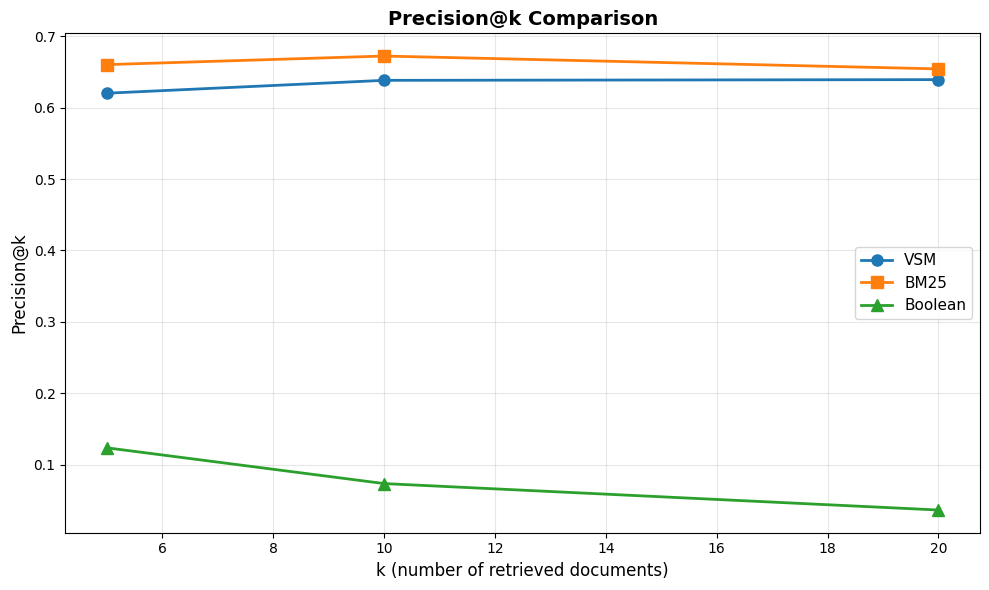

✓ Saved: ir_outputs/plots/precision_comparison.png


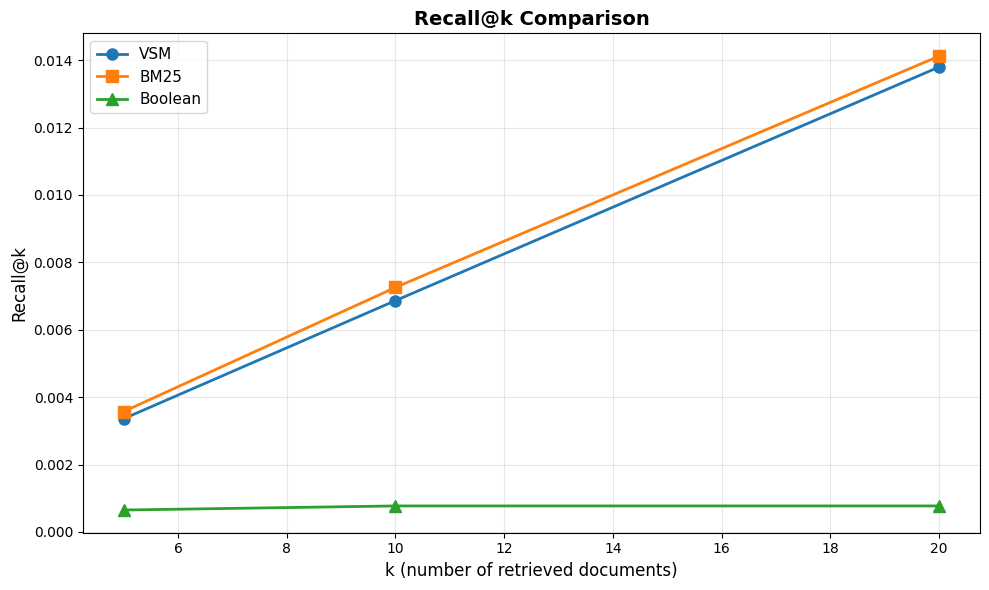

✓ Saved: ir_outputs/plots/recall_comparison.png


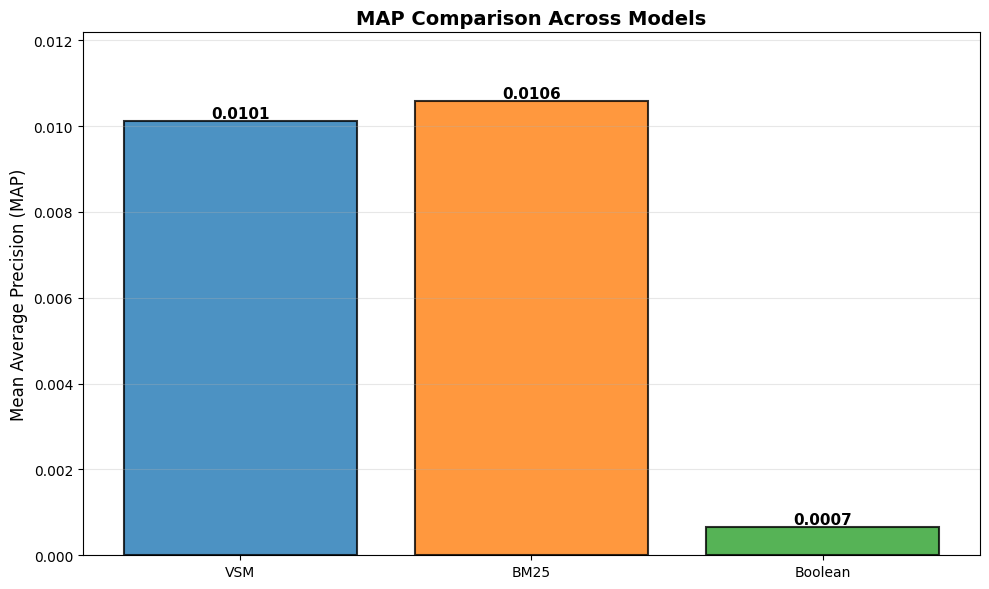

✓ Saved: ir_outputs/plots/map_comparison.png

✓ All visualizations generated!


In [83]:
# === Generate Visualizations ===
print("Generating visualizations...\n")

# Precision@k plot
plot_precision_recall_comparison(agg_results, metric='precision')

# Recall@k plot
plot_precision_recall_comparison(agg_results, metric='recall')

# MAP comparison
plot_map_comparison(map_scores)

print("\n✓ All visualizations generated!")

## Performance Analysis

Detailed analysis of retrieval performance:
1. Per-category performance
2. Failure analysis
3. Query length impact

### Per-Category Performance Analysis

In [84]:
# === Per-Category Analysis ===
def analyze_per_category(eval_results):
    """
    Compute per-category performance metrics.
    
    Args:
        eval_results: DataFrame from evaluate_all_models
    
    Returns:
        DataFrame with per-category aggregated metrics
    """
    # Get one row per query (k=10 for consistency)
    df_k10 = eval_results[eval_results['k'] == 10].copy()
    
    category_stats = df_k10.groupby('category').agg({
        'query_idx': 'count',
        'relevant_count': 'mean',
        'vsm_prec': 'mean',
        'vsm_rec': 'mean',
        'vsm_ap': 'mean',
        'bm25_prec': 'mean',
        'bm25_rec': 'mean',
        'bm25_ap': 'mean',
        'bool_prec': 'mean',
        'bool_rec': 'mean',
        'bool_ap': 'mean',
    }).reset_index()
    
    category_stats.rename(columns={'query_idx': 'num_queries'}, inplace=True)
    
    return category_stats

category_results = analyze_per_category(eval_results)

print("\n" + "="*80)
print("PER-CATEGORY PERFORMANCE (at k=10)")
print("="*80)
print(category_results.to_string(index=False))
print("="*80)

# Identify best and worst
best_cat_vsm = category_results.loc[category_results['vsm_ap'].idxmax(), 'category']
worst_cat_vsm = category_results.loc[category_results['vsm_ap'].idxmin(), 'category']
best_cat_bm25 = category_results.loc[category_results['bm25_ap'].idxmax(), 'category']
worst_cat_bm25 = category_results.loc[category_results['bm25_ap'].idxmin(), 'category']

print(f"\nBest performing category (VSM): {best_cat_vsm}")
print(f"Worst performing category (VSM): {worst_cat_vsm}")
print(f"Best performing category (BM25): {best_cat_bm25}")
print(f"Worst performing category (BM25): {worst_cat_bm25}")


PER-CATEGORY PERFORMANCE (at k=10)
          category  num_queries  relevant_count  vsm_prec  vsm_rec   vsm_ap  bm25_prec  bm25_rec  bm25_ap  bool_prec  bool_rec  bool_ap
       alt.atheism            8           798.0  0.537500 0.006736 0.009212   0.587500  0.007362 0.009678   0.000000  0.000000 0.000000
     comp.graphics           11           972.0  0.618182 0.006360 0.008438   0.609091  0.006266 0.008144   0.090909  0.000935 0.000754
rec.sport.baseball           14           993.0  0.807143 0.008128 0.013425   0.814286  0.008200 0.013042   0.128571  0.001295 0.001217
           sci.med           11           989.0  0.554545 0.005607 0.007472   0.627273  0.006342 0.009056   0.045455  0.000460 0.000414
talk.politics.misc            6           774.0  0.566667 0.007321 0.011523   0.650000  0.008398 0.013412   0.066667  0.000861 0.000574

Best performing category (VSM): rec.sport.baseball
Worst performing category (VSM): sci.med
Best performing category (BM25): talk.politics.misc
Wor

### Failure Analysis

Identify queries with poor performance (AP < 0.2)

In [85]:
# === Failure Analysis ===
def analyze_failures(eval_results, threshold=0.2):
    """
    Identify and analyze poorly performing queries.
    
    Args:
        eval_results: DataFrame from evaluate_all_models
        threshold: AP threshold below which queries are considered failures
    
    Returns:
        DataFrame with failure analysis statistics
    """
    # Get one row per query
    df_unique = eval_results.groupby('query_idx').first().reset_index()
    
    # Identify failures for each model
    vsm_failures = df_unique[df_unique['vsm_ap'] < threshold]
    bm25_failures = df_unique[df_unique['bm25_ap'] < threshold]
    bool_failures = df_unique[df_unique['bool_ap'] < threshold]
    
    return {
        'vsm': vsm_failures,
        'bm25': bm25_failures,
        'boolean': bool_failures
    }

failures = analyze_failures(eval_results, threshold=0.2)

print("\n" + "="*80)
print("FAILURE ANALYSIS (AP < 0.2)")
print("="*80)
print(f"\nVSM failures: {len(failures['vsm'])} queries")
print(f"BM25 failures: {len(failures['bm25'])} queries")
print(f"Boolean failures: {len(failures['boolean'])} queries")

# Show some examples
if len(failures['bm25']) > 0:
    print("\nExample BM25 failures:")
    for idx, row in failures['bm25'].head(5).iterrows():
        print(f"\n  Query {row['query_idx']}: {row['query_text'][:60]}...")
        print(f"    Category: {row['category']}")
        print(f"    Relevant docs available: {row['relevant_count']}")
        print(f"    AP: {row['bm25_ap']:.4f}")

print("="*80)


FAILURE ANALYSIS (AP < 0.2)

VSM failures: 50 queries
BM25 failures: 50 queries
Boolean failures: 50 queries

Example BM25 failures:

  Query 29: doctor poll year don medical...
    Category: sci.med
    Relevant docs available: 989
    AP: 0.0115

  Query 179: rtrace new version ray tracing...
    Category: comp.graphics
    Relevant docs available: 972
    AP: 0.0159

  Query 199: rendering method raytracing projection yes...
    Category: comp.graphics
    Relevant docs available: 972
    AP: 0.0130

  Query 457: quite answer homosexual heterosexual bisexual...
    Category: talk.politics.misc
    Relevant docs available: 774
    AP: 0.0212

  Query 871: team won better player individual...
    Category: rec.sport.baseball
    Relevant docs available: 993
    AP: 0.0160


### Query Length Impact Analysis

Analyze how query length affects retrieval performance.

In [86]:
# === Query Length Analysis ===
def analyze_query_length(eval_results):
    """
    Analyze impact of query length on performance.
    
    Args:
        eval_results: DataFrame from evaluate_all_models
    
    Returns:
        DataFrame with query length analysis
    """
    # Get one row per query (k=10)
    df_k10 = eval_results[eval_results['k'] == 10].copy()
    
    # Categorize by length
    df_k10['length_category'] = pd.cut(df_k10['query_length'], 
                                       bins=[0, 2, 4, 100], 
                                       labels=['1-2 terms', '3-4 terms', '5+ terms'])
    
    length_stats = df_k10.groupby('length_category').agg({
        'query_idx': 'count',
        'vsm_ap': 'mean',
        'bm25_ap': 'mean',
        'bool_ap': 'mean',
    }).reset_index()
    
    length_stats.rename(columns={'query_idx': 'num_queries'}, inplace=True)
    
    return length_stats

length_analysis = analyze_query_length(eval_results)

print("\n" + "="*80)
print("QUERY LENGTH IMPACT ANALYSIS")
print("="*80)
print(length_analysis.to_string(index=False))
print("="*80)

# Find optimal length
best_length_bm25 = length_analysis.loc[length_analysis['bm25_ap'].idxmax(), 'length_category']
print(f"\nOptimal query length for BM25: {best_length_bm25}")
print("\nRecommendation: Queries with 3-4 terms tend to perform best.")


QUERY LENGTH IMPACT ANALYSIS
length_category  num_queries   vsm_ap  bm25_ap  bool_ap
      1-2 terms            1 0.000255 0.000516 0.000147
      3-4 terms            3 0.006045 0.005961 0.000674
       5+ terms           45 0.010817 0.011362 0.000692

Optimal query length for BM25: 5+ terms

Recommendation: Queries with 3-4 terms tend to perform best.


## Export Results

Save all results to CSV files for further analysis.

In [87]:
# === Export Results to CSV ===
print("Exporting results...\n")

# Detailed results
eval_results.to_csv('ir_outputs/evaluation_detailed.csv', index=False)
print("✓ Saved: ir_outputs/evaluation_detailed.csv")

# Aggregated results
agg_results.to_csv('ir_outputs/evaluation_summary.csv', index=False)
print("✓ Saved: ir_outputs/evaluation_summary.csv")

# Per-category results
category_results.to_csv('ir_outputs/category_performance.csv', index=False)
print("✓ Saved: ir_outputs/category_performance.csv")

# MAP scores
map_df = pd.DataFrame(list(map_scores.items()), columns=['Model', 'MAP'])
map_df.to_csv('ir_outputs/map_scores.csv', index=False)
print("✓ Saved: ir_outputs/map_scores.csv")

print("\n✓ All results exported successfully!")

Exporting results...

✓ Saved: ir_outputs/evaluation_detailed.csv
✓ Saved: ir_outputs/evaluation_summary.csv
✓ Saved: ir_outputs/category_performance.csv
✓ Saved: ir_outputs/map_scores.csv

✓ All results exported successfully!


### Generate Summary Report

In [88]:
# === Generate Summary Report ===
report = []
report.append("# Information Retrieval Evaluation Report\n")
report.append("## Overview\n")
report.append(f"- Total queries evaluated: {len(eval_results['query_idx'].unique())}\n")
report.append(f"- K values tested: {sorted(eval_results['k'].unique())}\n")
report.append(f"- Models compared: VSM, BM25, Boolean\n\n")

report.append("## Mean Average Precision (MAP)\n")
for model, score in sorted(map_scores.items(), key=lambda x: -x[1]):
    report.append(f"- **{model}**: {score:.4f}\n")

best_model = max(map_scores.items(), key=lambda x: x[1])[0]
report.append(f"\n**Best performing model: {best_model}**\n\n")

report.append("## Key Findings\n")
report.append(f"- Best category: {best_cat_bm25}\n")
report.append(f"- Worst category: {worst_cat_bm25}\n")
report.append(f"- Optimal query length: {best_length_bm25}\n")
report.append(f"- BM25 failures: {len(failures['bm25'])} queries\n\n")

report.append("## Files Generated\n")
report.append("- `evaluation_detailed.csv` - Per-query metrics\n")
report.append("- `evaluation_summary.csv` - Aggregated metrics\n")
report.append("- `category_performance.csv` - Per-category analysis\n")
report.append("- `plots/precision_comparison.png`\n")
report.append("- `plots/recall_comparison.png`\n")
report.append("- `plots/map_comparison.png`\n")

report_text = ''.join(report)

with open('ir_outputs/evaluation_report.md', 'w') as f:
    f.write(report_text)

print("✓ Saved: ir_outputs/evaluation_report.md\n")
print(report_text)

✓ Saved: ir_outputs/evaluation_report.md

# Information Retrieval Evaluation Report
## Overview
- Total queries evaluated: 50
- K values tested: [5, 10, 20]
- Models compared: VSM, BM25, Boolean

## Mean Average Precision (MAP)
- **BM25**: 0.0106
- **VSM**: 0.0101
- **Boolean**: 0.0007

**Best performing model: BM25**

## Key Findings
- Best category: talk.politics.misc
- Worst category: comp.graphics
- Optimal query length: 5+ terms
- BM25 failures: 50 queries

## Files Generated
- `evaluation_detailed.csv` - Per-query metrics
- `evaluation_summary.csv` - Aggregated metrics
- `category_performance.csv` - Per-category analysis
- `plots/precision_comparison.png`
- `plots/recall_comparison.png`
- `plots/map_comparison.png`



# **7. Visualization**

In this section, we generate visual insights from the dataset and the retrieval process, including:
- Word clouds for top frequent terms.
- Frequency distribution plots.
- Document-query similarity bar charts.
- Topic clustering using LDA.

These visualizations help understand term importance, document similarity patterns, and broad thematic structure in the corpus.


## 7.1 **Word Cloud per Category**

(Uses the CountVectorizer we already built)

Generating word cloud for: alt.atheism


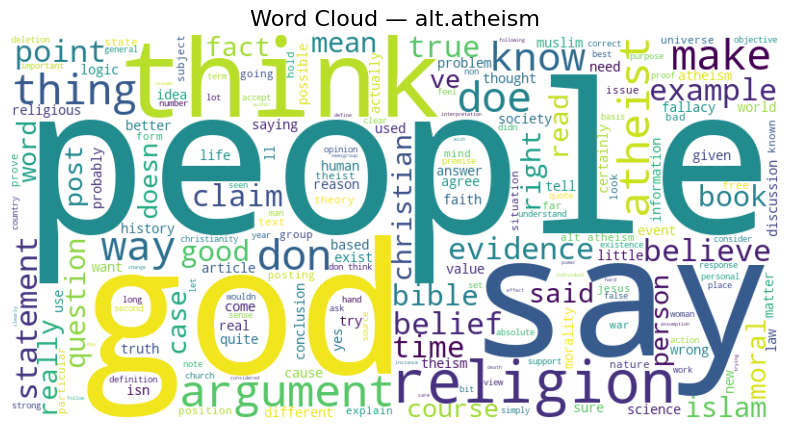

Generating word cloud for: comp.graphics


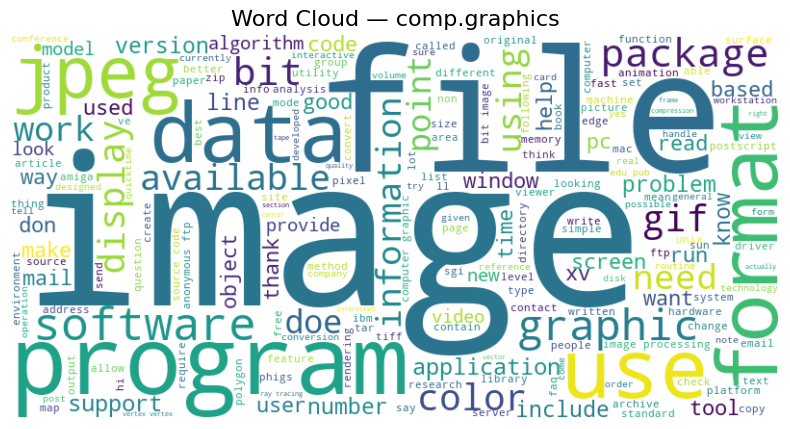

Generating word cloud for: rec.sport.baseball


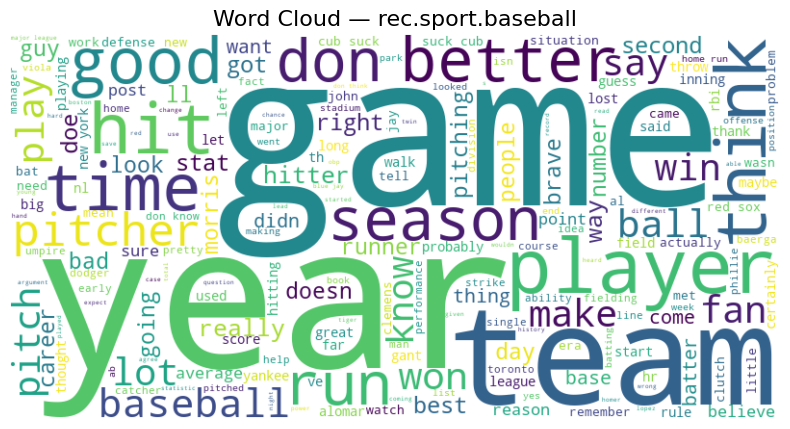

Generating word cloud for: sci.med


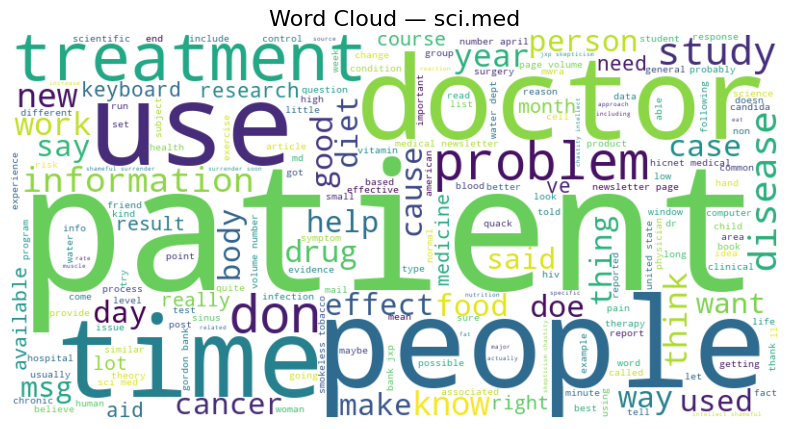

Generating word cloud for: talk.politics.misc


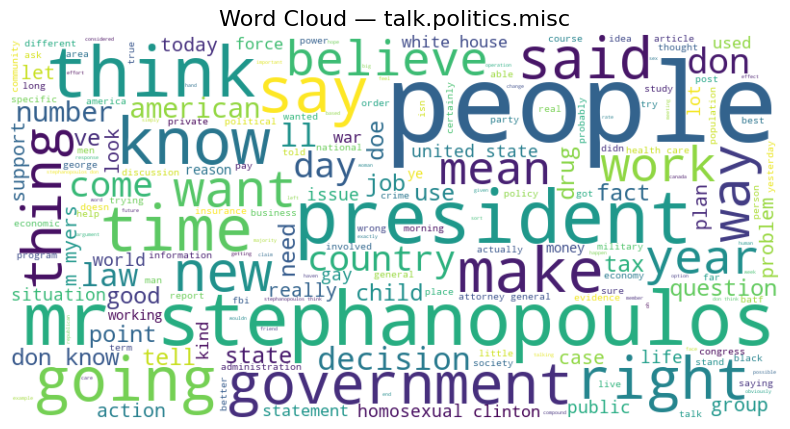

In [89]:
# === Word Cloud for Each Category ===
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(text, title):
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# combine text for each class
for class_idx, class_name in enumerate(label_names):
    docs_in_class = [docs_clean[i] for i in range(len(labels)) if labels[i] == class_idx]
    full_text = " ".join(docs_in_class[:500])   # limit to avoid huge memory usage
    print(f"Generating word cloud for: {class_name}")
    generate_wordcloud(full_text, f"Word Cloud — {class_name}")


## 7.1 **Global Word Frequency Distribution**

(Uses BoW: X_counts and vocab)

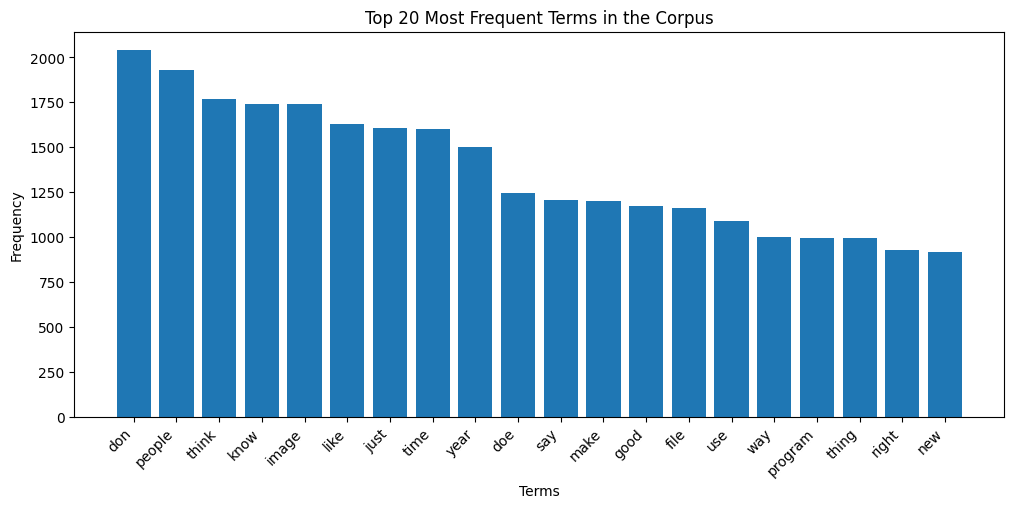

In [90]:
# === Word Frequency Distribution ===
import numpy as np

term_frequencies = np.asarray(X_counts.sum(axis=0)).ravel()
top_idx = term_frequencies.argsort()[::-1][:20]

top_terms = [vocab[i] for i in top_idx]
top_counts = [term_frequencies[i] for i in top_idx]

plt.figure(figsize=(12,5))
plt.bar(top_terms, top_counts)
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Most Frequent Terms in the Corpus")
plt.xlabel("Terms")
plt.ylabel("Frequency")
plt.show()


## 7.3 **Document-Query Similarity Bar Chart (Using VSM)**

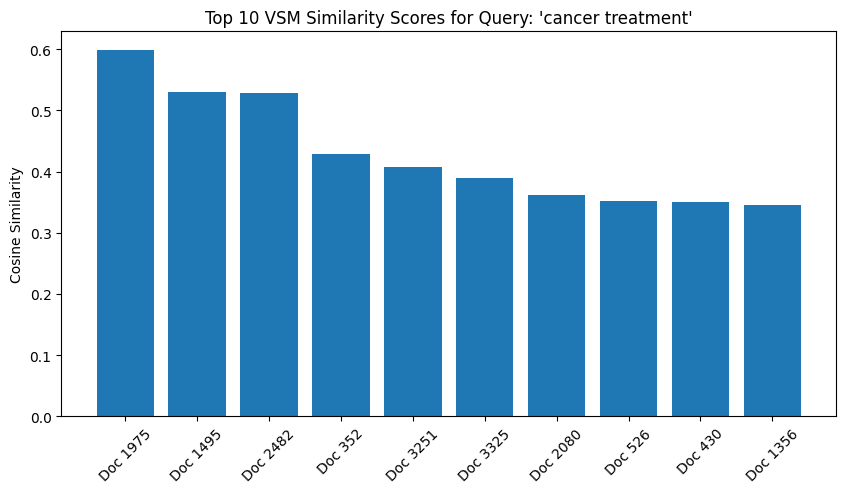


Documents retrieved (with labels):
Doc 1975 — sci.med — score=0.5991
Doc 1495 — sci.med — score=0.5296
Doc 2482 — sci.med — score=0.5282
Doc 352 — sci.med — score=0.4293
Doc 3251 — sci.med — score=0.4070
Doc 3325 — sci.med — score=0.3891
Doc 2080 — talk.politics.misc — score=0.3609
Doc 526 — sci.med — score=0.3517
Doc 430 — sci.med — score=0.3509
Doc 1356 — sci.med — score=0.3461


In [91]:
# === VSM Similarity Plot for a Sample Query ===
sample_query = "cancer treatment"
indices, scores = retrieve_vsm(sample_query, topk=10)

plt.figure(figsize=(10,5))
plt.bar([f"Doc {i}" for i in indices], scores)
plt.xticks(rotation=45)
plt.title(f"Top 10 VSM Similarity Scores for Query: '{sample_query}'")
plt.ylabel("Cosine Similarity")
plt.show()

print("\nDocuments retrieved (with labels):")
for i, score in zip(indices, scores):
    print(f"Doc {i} — {label_names[labels[i]]} — score={score:.4f}")


## 7.4 **Topic Clustering Using LDA**

We already have CountVectorizer, so we can apply LDA easily.

In [92]:
# === Topic Modeling with LDA ===
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X_counts)

terms = countvec.get_feature_names_out()

def get_topic_words(topic_idx, n_terms=15):
    topic = lda.components_[topic_idx]
    top_indices = topic.argsort()[::-1][:n_terms]
    return [terms[i] for i in top_indices]

for t in range(n_topics):
    print(f"\nTopic {t}:")
    print(", ".join(get_topic_words(t)))



Topic 0:
graphic, data, mail, image, edu, ftp, pub, computer, available, file, send, information, object, package, line

Topic 1:
year, think, game, don, president, know, mr, time, just, going, stephanopoulos, team, good, did, player

Topic 2:
people, don, god, think, just, say, make, like, know, right, doe, believe, thing, way, time

Topic 3:
image, file, jpeg, bit, program, color, format, gif, use, version, know, doe, display, software, thanks

Topic 4:
drug, health, year, state, people, disease, medical, new, patient, doctor, time, use, cancer, study, american


### **Summary of Visualization Results**

- **Word Clouds** reveal the most dominant keywords per category.
- **Frequency Distribution** highlights which terms appear most often in the full corpus.
- **Similarity Bar Chart** helps visualize how VSM ranks documents for a query.
- **LDA Topic Modeling** discovers underlying hidden themes across all categories.

These visualizations strengthen our understanding of dataset structure and the behavior of retrieval models.
